In [1]:
from __future__ import print_function

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf
'''
from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()
'''
import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import seaborn as sns

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize

import h5py

#Visualization code

import matplotlib

def ic_scale(pwm,background):
    per_position_ic = util.compute_per_position_ic(
                       ppm=pwm, background=background, pseudocount=0.001)
    return pwm*(per_position_ic[:,None])


def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(matplotlib.patches.Polygon((np.array([1,height])[None,:]*polygon_coords
                                                 + np.array([left_edge,base])[None,:]),
                                                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.825, base+0.085*height], width=0.174, height=0.415*height,
                                            facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.625, base+0.35*height], width=0.374, height=0.15*height,
                                            facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
                  width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
                  width=1.0, height=0.2*height, facecolor=color, edgecolor=color, fill=True))

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
def plot_weights_given_ax(ax, array,
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=1.0,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={},
                 ylabel=""):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(-length_padding, array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(0.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_weights_given_ax(ax=ax, array=array,**kwargs)
    plt.show()


def plot_score_track_given_ax(arr, ax, threshold=None, **kwargs):
    ax.plot(np.arange(len(arr)), arr, **kwargs)
    if (threshold is not None):
        ax.plot([0, len(arr)-1], [threshold, threshold])
    ax.set_xlim(0,len(arr)-1)

from matplotlib.ticker import FormatStrFormatter

def plot_score_track(arr, threshold=None, figsize=(20,2), **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_score_track_given_ax(arr, threshold=threshold, ax=ax, **kwargs) 
    plt.show()

def plot_pwm(weights, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :
    colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
    
    plot_funcs = {0: plot_a, 1: plot_c, 
                  2: plot_g, 3: plot_t}

    fig = plt.figure(figsize=figsize)
    
    ax = fig.add_subplot(111) 
    
    plot_weights_given_ax(ax=ax, array=weights, 
                                       height_padding_factor=0.2,
                                       length_padding=1.0, 
                                       subticks_frequency=1.0, 
                                       colors=colors, plot_funcs=plot_funcs, 
                                       highlight={}, ylabel="")

    plt.sca(ax)
    
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    
    plt.tight_layout()
    
    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=600)
        plt.savefig(fig_name + ".eps")
    
    plt.show()

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()

def plot_pwm_2(pwm, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :
    
    fig = plt.figure(figsize=figsize)

    ax = plt.gca()
    
    height_base = 0.
    logo_height = 1.0
    
    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i]# * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if ii == 0 :
                dna_letter_at(nt, j + 0.5, height_base, nt_prob * logo_height, ax, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]]) * logo_height # * conservation[j]
                dna_letter_at(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, pwm.shape[0]))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            min(0., np.min(np.sum(pwm, axis=-1))) - 0.01 * np.max(np.abs(np.sum(pwm, axis=-1))),
            max(0., np.max(np.sum(pwm, axis=-1))) + 0.01 * np.max(np.abs(np.sum(pwm, axis=-1)))
        )
    
    print(np.min(np.sum(pwm, axis=-1)) - 0.1 * np.max(np.abs(np.sum(pwm, axis=-1))))
    print(np.max(np.sum(pwm, axis=-1)) + 0.1 * np.max(np.abs(np.sum(pwm, axis=-1))))
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()

#One-hot-encoder
class SequenceEncoder :
    
    def __init__(self, encoder_type_id, encode_dims) :
        self.encoder_type_id = encoder_type_id
        self.encode_dims = encode_dims
    
    def encode(self, seq) :
        raise NotImplementedError()
    
    def encode_inplace(self, seq, encoding) :
        raise NotImplementedError()
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def decode(self, encoding) :
        raise NotImplementedError()
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def __call__(self, seq) :
        return self.encode(seq)
    
class OneHotEncoder(SequenceEncoder) :
    
    def __init__(self, seq_length, channel_map) :
        super(OneHotEncoder, self).__init__('onehot', (seq_length, len(channel_map)))
        
        self.seq_len = seq_length
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += self.decode_map[self.n_channels - 1]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)


Using TensorFlow backend.
2023-04-25 23:43:22.998086: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


In [2]:

df = pd.read_csv('polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

save_dict = np.load("polyadb_features_pas_3_utr3_perturb.npz")
x, m, l, c, y = save_dict['x'], save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y']

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))


x.shape = (5267, 10, 205, 4)
m.shape = (5267, 10)
l.shape = (5267, 10)
c.shape = (5267, 10, 28)
y.shape = (5267, 10, 28)


In [3]:
#Cache/Load APARENT2 baseline score

#np.save("polyadb_features_pas_3_utr3_perturb_aparent2_all_scores", s)
s = np.load("polyadb_features_pas_3_utr3_perturb_aparent2_all_scores.npy")

print(s.shape)


(5267, 10)


In [4]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i:i+1, dist_index[i], :])

y_dist = np.concatenate(y_dist, axis=0)

print(y_dist.shape)


(5267, 28)


In [5]:
#Load tissue-specific PAS model and generate scores for select tissue types

subset_cell_types = np.array([
    'NT',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'FIP1L1',
    'NUDT21',
    'RBBP6',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

subset_cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(subset_cell_types)
}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [6]:
#Define tissue-/cell- types

cell_types = np.array([
    'rpm',
    'NT',
    'CDC73',
    'CPSF1',
    'CPSF2',
    'CPSF3',
    'CPSF3L',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'CTR9',
    'FIP1L1',
    'LEO1',
    'NUDT21',
    'PABPC1',
    'PABPN1',
    'PAF1',
    'PAPOLA',
    'PCF11',
    'RBBP6',
    'RPRD1A',
    'RPRD1B',
    'SCAF8',
    'SF3A1',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [7]:
#Model parameters

n_bootstraps = 5
n_cell_types = subset_cell_types.shape[0]


In [8]:
#Cache/Load tissue scores
'''
np.save("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts_ensemble", ts_ensemble)
np.save("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts", ts)
'''
ts_ensemble = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts_ensemble.npy")
ts = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts.npy")

print(ts_ensemble.shape)
print(ts.shape)


(5267, 10, 11, 3, 5)
(5267, 10, 11, 3)


In [9]:
#Compute normalization statistics

cell_type_ixs = [cell_type_dict[ct] for ct in subset_cell_types.tolist()]

flat_x = np.reshape(x, (x.shape[0] * x.shape[1], 1, 205, 4))
flat_ts_ensemble = np.reshape(ts_ensemble, (x.shape[0] * x.shape[1], n_cell_types, n_bootstraps, 3))
flat_ts = np.reshape(ts, (x.shape[0] * x.shape[1], n_cell_types, 3))
flat_s = np.reshape(s, (x.shape[0] * x.shape[1],))
flat_y = np.reshape(y[:, :, cell_type_ixs], (x.shape[0] * x.shape[1], n_cell_types))
flat_gene_ind = np.reshape(np.tile(np.arange(x.shape[0])[:, None], (1, x.shape[1])), (x.shape[0] * x.shape[1],))
flat_pas_ind = np.reshape(np.tile(np.arange(x.shape[1])[None, :], (x.shape[0], 1)), (x.shape[0] * x.shape[1],))

flat_m = np.reshape(m, (x.shape[0] * x.shape[1],))
flat_dist_mask = np.reshape(dist_mask, (x.shape[0] * x.shape[1],))

flat_keep_index = np.nonzero(flat_m >= 1)[0]

flat_x = flat_x[flat_keep_index, ...]
flat_ts_ensemble = flat_ts_ensemble[flat_keep_index, ...]
flat_ts = flat_ts[flat_keep_index, ...]
flat_s = flat_s[flat_keep_index, ...]
flat_y = flat_y[flat_keep_index, ...]
flat_gene_ind = flat_gene_ind[flat_keep_index, ...]
flat_pas_ind = flat_pas_ind[flat_keep_index, ...]

flat_m = flat_m[flat_keep_index, ...]
flat_dist_mask = flat_dist_mask[flat_keep_index, ...]


In [10]:
#Construct masks for proximal/middle/distal sites

flat_prox_mask = np.array((flat_pas_ind == 0), dtype=np.float32)
flat_middle_mask = 1. - flat_dist_mask - flat_prox_mask

flat_masks = [
    flat_prox_mask,
    flat_middle_mask,
    flat_dist_mask
]


In [11]:
#Load processed (flattened) PAS IDs from original dataframe

flat_ids = np.load("polyadb_features_pas_3_utr3_perturb_flat_ids.npy", allow_pickle=True)

#Compile and flatten gene names
flat_gene_names = []
for _, row in df.iterrows() :
    flat_gene_names.extend([row['gene'] for k in range(m.shape[1]) if row['pas_exists_' + str(k)] == 1])

flat_gene_names = np.array(flat_gene_names, dtype=object)


In [12]:
#Re-load gated importance scores

flat_scores = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_flat_g_scores.npy")
flat_scores = np.tile(flat_scores, (1, 1, 1, 1, 1, 4)) * flat_x[None, None, ...]

print("flat_scores.shape = " + str(flat_scores.shape))

#Re-load gated importance scores (bootstrap replicates)

n_bootstraps_ism = 3

flat_scores_ensemble = []

for bootstrap_ix in range(n_bootstraps_ism) :
    flat_scores_curr = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_flat_g_scores_bootstrap_" + str(bootstrap_ix) + ".npy")
    flat_scores_curr = np.tile(flat_scores_curr, (1, 1, 1, 1, 1, 4)) * flat_x[None, None, ...]
    
    flat_scores_ensemble.append(flat_scores_curr)
    
    print("(bootstrap_ix = " + str(bootstrap_ix) + ") flat_scores.shape = " + str(flat_scores_curr.shape))


flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 0) flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 1) flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 2) flat_scores.shape = (11, 3, 14764, 1, 205, 4)


In [13]:
#Merge proximal/middle/distal predictions and ISM scores

flat_ts_merged = np.zeros((flat_x.shape[0], n_cell_types))

flat_ts_merged[flat_prox_mask == 1., ...] = flat_ts[flat_prox_mask == 1., ..., 0]
flat_ts_merged[flat_middle_mask == 1., ...] = flat_ts[flat_middle_mask == 1., ..., 1]
flat_ts_merged[flat_dist_mask == 1., ...] = flat_ts[flat_dist_mask == 1., ..., 2]

flat_scores_merged = np.zeros((n_cell_types, flat_x.shape[0], 1, 205, 4))

flat_scores_merged[:, flat_prox_mask == 1., ...] = flat_scores[:, 0, flat_prox_mask == 1., ...]
flat_scores_merged[:, flat_middle_mask == 1., ...] = flat_scores[:, 1, flat_middle_mask == 1., ...]
flat_scores_merged[:, flat_dist_mask == 1., ...] = flat_scores[:, 2, flat_dist_mask == 1., ...]


In [14]:
#Calculate 'native' background nucleotide frequencies
s_qtl_lo = np.quantile(flat_s, q=0.0)
s_qtl_hi = np.quantile(flat_s, q=1.0)

filter_index = np.nonzero((flat_s >= s_qtl_lo) & (flat_s < s_qtl_hi))[0]

#Calculate filtered mononucleotide background frequencies
mononuc_native = np.sum(flat_x[filter_index, 0, 0:146, :], axis=(0, 1)) / np.sum(flat_x[filter_index, 0, 0:146, :])

print("mononuc_native = " + str(np.round(mononuc_native, 2).tolist()))

#Calculate 'neutral' background nucleotide frequencies
s_qtl_lo = np.quantile(flat_s, q=0.45)
s_qtl_hi = np.quantile(flat_s, q=0.55)

filter_index = np.nonzero((flat_s >= s_qtl_lo) & (flat_s < s_qtl_hi))[0]

#Calculate filtered mononucleotide background frequencies
mononuc_neutral = np.sum(flat_x[filter_index, 0, 0:146, :], axis=(0, 1)) / np.sum(flat_x[filter_index, 0, 0:146, :])

print("mononuc_neutral = " + str(np.round(mononuc_neutral, 2).tolist()))

#Calculate 'weak' background nucleotide frequencies
s_qtl_lo = np.quantile(flat_s, q=0.0)
s_qtl_hi = np.quantile(flat_s, q=0.1)

filter_index = np.nonzero((flat_s >= s_qtl_lo) & (flat_s < s_qtl_hi))[0]

#Calculate filtered mononucleotide background frequencies
mononuc_weak = np.sum(flat_x[filter_index, 0, 0:146, :], axis=(0, 1)) / np.sum(flat_x[filter_index, 0, 0:146, :])

print("mononuc_weak = " + str(np.round(mononuc_weak, 2).tolist()))

#Calculate 'stong' background nucleotide frequencies
s_qtl_lo = np.quantile(flat_s, q=0.9)
s_qtl_hi = np.quantile(flat_s, q=1.0)

filter_index = np.nonzero((flat_s >= s_qtl_lo) & (flat_s < s_qtl_hi))[0]

#Calculate filtered mononucleotide background frequencies
mononuc_stong = np.sum(flat_x[filter_index, 0, 0:146, :], axis=(0, 1)) / np.sum(flat_x[filter_index, 0, 0:146, :])

print("mononuc_stong = " + str(np.round(mononuc_stong, 2).tolist()))


mononuc_native = [0.3, 0.17, 0.18, 0.35]
mononuc_neutral = [0.31, 0.17, 0.17, 0.35]
mononuc_weak = [0.28, 0.2, 0.21, 0.31]
mononuc_stong = [0.3, 0.15, 0.16, 0.39]


In [15]:
#Function to visualize sequence designs

def _visualize_designs(save_prefix, n_sequences, window_size, cell_type_1_ix, cell_type_2_ix, pred_cell_type_2_ix, score_ix, shuffle_region, top_k_mers=10, mer_len=5) :
    
    print("prefix = '" + save_prefix + "'")
    
    print("-- " + "'apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_" + str(cell_type_2_ix) + "_score_ix_" + str(score_ix) + "_n_sequences_" + str(n_sequences) + "_" + str(shuffle_region) + "_window_size_" + str(window_size) + "' --")
    print("")
    
    df_pos = pd.read_csv("samples/" + save_prefix + "window_size_" + str(window_size) + "_score_ix_" + str(score_ix) + "/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_" + str(cell_type_2_ix) + "_score_ix_" + str(score_ix) + "_n_sequences_" + str(n_sequences) + "_" + str(shuffle_region) + "_window_size_" + str(window_size) + "_pos.txt", sep='\t')
    df_neg = pd.read_csv("samples/" + save_prefix + "window_size_" + str(window_size) + "_score_ix_" + str(score_ix) + "/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_" + str(cell_type_2_ix) + "_score_ix_" + str(score_ix) + "_n_sequences_" + str(n_sequences) + "_" + str(shuffle_region) + "_window_size_" + str(window_size) + "_neg.txt", sep='\t')
    df_neutral = pd.read_csv("samples/" + save_prefix + "window_size_" + str(window_size) + "_score_ix_" + str(score_ix) + "/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_" + str(cell_type_2_ix) + "_score_ix_" + str(score_ix) + "_n_sequences_" + str(n_sequences) + "_" + str(shuffle_region) + "_window_size_" + str(window_size) + "_neutral.txt", sep='\t')

    #Specify cell type index to use for predictions
    df_pos['diff_score_0'] = df_pos['diff_ct_' + str(pred_cell_type_2_ix) + '_score_0']
    df_pos['diff_score_1'] = df_pos['diff_ct_' + str(pred_cell_type_2_ix) + '_score_1']
    df_pos['diff_score_2'] = df_pos['diff_ct_' + str(pred_cell_type_2_ix) + '_score_2']
    
    df_neg['diff_score_0'] = df_neg['diff_ct_' + str(pred_cell_type_2_ix) + '_score_0']
    df_neg['diff_score_1'] = df_neg['diff_ct_' + str(pred_cell_type_2_ix) + '_score_1']
    df_neg['diff_score_2'] = df_neg['diff_ct_' + str(pred_cell_type_2_ix) + '_score_2']
    
    df_neutral['diff_score_0'] = df_neutral['diff_ct_' + str(pred_cell_type_2_ix) + '_score_0']
    df_neutral['diff_score_1'] = df_neutral['diff_ct_' + str(pred_cell_type_2_ix) + '_score_1']
    df_neutral['diff_score_2'] = df_neutral['diff_ct_' + str(pred_cell_type_2_ix) + '_score_2']
    
    #Get wt dataframes
    df_pos_wt = df_pos.query("experiment == 'wt'").copy().reset_index(drop=True)
    df_neg_wt = df_neg.query("experiment == 'wt'").copy().reset_index(drop=True)
    df_neutral_wt = df_neutral.query("experiment == 'wt'").copy().reset_index(drop=True)

    #Get non-wt dataframes
    df_pos = df_pos.query("experiment != 'wt'").copy().reset_index(drop=True)
    df_neg = df_neg.query("experiment != 'wt'").copy().reset_index(drop=True)
    df_neutral = df_neutral.query("experiment != 'wt'").copy().reset_index(drop=True)

    #Augment with wt predictions
    df_pos = df_pos.join(df_pos_wt[['pas_id', 'diff_score_0', 'diff_score_1', 'diff_score_2']].set_index("pas_id"), on='pas_id', how='inner', rsuffix='_wt').copy().reset_index(drop=True)
    df_neg = df_neg.join(df_neg_wt[['pas_id', 'diff_score_0', 'diff_score_1', 'diff_score_2']].set_index("pas_id"), on='pas_id', how='inner', rsuffix='_wt').copy().reset_index(drop=True)
    df_neutral = df_neutral.join(df_neutral_wt[['pas_id', 'diff_score_0', 'diff_score_1', 'diff_score_2']].set_index("pas_id"), on='pas_id', how='inner', rsuffix='_wt').copy().reset_index(drop=True)

    #Aggregate over replicates

    df_pos['superexperiment'] = df_pos['experiment'].apply(lambda x: x.split("_repeat")[0])
    df_pos = df_pos.groupby(['pas_id', 'superexperiment']).agg({
        'gene_id' : 'first',
        'experiment' : 'first',
        'seq' : 'first',
        'diff_score_0' : 'mean',
        'diff_score_1' : 'mean',
        'diff_score_2' : 'mean',
        'diff_score_0_wt' : 'first',
        'diff_score_1_wt' : 'first',
        'diff_score_2_wt' : 'first'
    }).copy().reset_index().reset_index(drop=True)

    df_neg['superexperiment'] = df_neg['experiment'].apply(lambda x: x.split("_repeat")[0])
    df_neg = df_neg.groupby(['pas_id', 'superexperiment']).agg({
        'gene_id' : 'first',
        'experiment' : 'first',
        'seq' : 'first',
        'diff_score_0' : 'mean',
        'diff_score_1' : 'mean',
        'diff_score_2' : 'mean',
        'diff_score_0_wt' : 'first',
        'diff_score_1_wt' : 'first',
        'diff_score_2_wt' : 'first'
    }).copy().reset_index().reset_index(drop=True)

    df_neutral['superexperiment'] = df_neutral['experiment'].apply(lambda x: x.split("_repeat")[0])
    df_neutral = df_neutral.groupby(['pas_id', 'superexperiment']).agg({
        'gene_id' : 'first',
        'experiment' : 'first',
        'seq' : 'first',
        'diff_score_0' : 'mean',
        'diff_score_1' : 'mean',
        'diff_score_2' : 'mean',
        'diff_score_0_wt' : 'first',
        'diff_score_1_wt' : 'first',
        'diff_score_2_wt' : 'first'
    }).copy().reset_index().reset_index(drop=True)

    #Get shuffle_1 dataframes
    df_pos_shuffle_1 = df_pos.loc[df_pos['experiment'].str.contains("shuffle_1_p")].copy().reset_index(drop=True)
    df_neg_shuffle_1 = df_neg.loc[df_neg['experiment'].str.contains("shuffle_1_p")].copy().reset_index(drop=True)
    df_neutral_shuffle_1 = df_neutral.loc[df_neutral['experiment'].str.contains("shuffle_1_p")].copy().reset_index(drop=True)

    #Get shuffle_2 dataframes
    df_pos_shuffle_2 = df_pos.loc[df_pos['experiment'].str.contains("shuffle_2_p")].copy().reset_index(drop=True)
    df_neg_shuffle_2 = df_neg.loc[df_neg['experiment'].str.contains("shuffle_2_p")].copy().reset_index(drop=True)

    #Get shuffle_1_and_2 dataframes
    df_pos_shuffle_1_and_2 = df_pos.loc[df_pos['experiment'].str.contains("shuffle_1_and_2_p")].copy().reset_index(drop=True)
    df_neg_shuffle_1_and_2 = df_neg.loc[df_neg['experiment'].str.contains("shuffle_1_and_2_p")].copy().reset_index(drop=True)

    print("len(df_pos_wt) = " + str(len(df_pos_wt)))
    print("len(df_neg_wt) = " + str(len(df_neg_wt)))
    print("len(df_neutral_wt) = " + str(len(df_neutral_wt)))
    print("")

    print("len(df_pos_shuffle_1) = " + str(len(df_pos_shuffle_1)))
    print("len(df_neg_shuffle_1) = " + str(len(df_neg_shuffle_1)))
    print("len(df_neutral_shuffle_1) = " + str(len(df_neutral_shuffle_1)))
    print("")

    print("len(df_pos_shuffle_2) = " + str(len(df_pos_shuffle_2)))
    print("len(df_neg_shuffle_2) = " + str(len(df_neg_shuffle_2)))
    print("")

    print("len(df_pos_shuffle_1_and_2) = " + str(len(df_pos_shuffle_1_and_2)))
    print("len(df_neg_shuffle_1_and_2) = " + str(len(df_neg_shuffle_1_and_2)))
    
    #Distribution of model scores (split by distal/non-distal PASs); scored by distal or proximal model
    pred_score_ixs = [2, 0]

    for pred_score_ix in pred_score_ixs :
        flat_ts_diff = (flat_ts[:, cell_type_1_ix, pred_score_ix] - flat_ts[:, pred_cell_type_2_ix, pred_score_ix])[flat_masks[pred_score_ix] == 1.]

        wt_pos_diff = np.array(df_pos_wt['diff_score_' + str(pred_score_ix)].values)
        wt_neg_diff = np.array(df_neg_wt['diff_score_' + str(pred_score_ix)].values)
        wt_neutral_diff = np.array(df_neutral_wt['diff_score_' + str(pred_score_ix)].values)

        score_range = (np.min(flat_ts_diff), np.max(flat_ts_diff))

        f = plt.figure(figsize=(12, 4))

        plt.hist(flat_ts_diff, color='black', alpha=0.25, bins=50, range=score_range, density=False, label='All WT Seqs')
        plt.hist(wt_pos_diff, color='red', alpha=0.5, bins=50, range=score_range, density=False, label='Top WT (Pos)')
        plt.hist(wt_neg_diff, color='green', alpha=0.5, bins=50, range=score_range, density=False, label='Top WT (Neg)')
        plt.hist(wt_neutral_diff, color='blue', alpha=0.5, bins=50, range=score_range, density=False, label='Top WT (Neutral)')

        plt.xlabel("Score[" + subset_cell_types[cell_type_1_ix] + "] - Score[" + subset_cell_types[pred_cell_type_2_ix] + "] " + ("(Prox)" if pred_score_ix == 0 else "(Dist)"), fontsize=12)
        plt.ylabel("Density of PASs", fontsize=12)

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.xlim(score_range[0], score_range[1])

        plt.legend(fontsize=12)

        plt.tight_layout()

        plt.show()

    #Compare proximal and distal predictions of 
    from scipy.stats import spearmanr

    wt_pos_diff_0 = np.array(df_pos_wt['diff_score_0'].values)
    wt_neg_diff_0 = np.array(df_neg_wt['diff_score_0'].values)
    wt_neutral_diff_0 = np.array(df_neutral_wt['diff_score_0'].values)

    wt_pos_diff_2 = np.array(df_pos_wt['diff_score_2'].values)
    wt_neg_diff_2 = np.array(df_neg_wt['diff_score_2'].values)
    wt_neutral_diff_2 = np.array(df_neutral_wt['diff_score_2'].values)

    wt_diff_0 = np.concatenate([wt_neg_diff_0, wt_neutral_diff_0, wt_pos_diff_0], axis=0)
    wt_diff_2 = np.concatenate([wt_neg_diff_2, wt_neutral_diff_2, wt_pos_diff_2], axis=0)

    r_val, _ = spearmanr(wt_diff_0, wt_diff_2)

    f = plt.figure(figsize=(4, 4))

    plt.scatter(wt_pos_diff_0, wt_pos_diff_2, color='red', s=50, edgecolor='black', linewidth=0.75, label='Top WT (Pos)')
    plt.scatter(wt_neg_diff_0, wt_neg_diff_2, color='green', s=50, edgecolor='black', linewidth=0.75, label='Top WT (Neg)')
    plt.scatter(wt_neutral_diff_0, wt_neutral_diff_2, color='blue', s=50, edgecolor='black', linewidth=0.75, label='Top WT (Neutral)')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Score[" + subset_cell_types[cell_type_1_ix] + "] - Score[" + subset_cell_types[pred_cell_type_2_ix] + "] (Prox)", fontsize=12)
    plt.ylabel("Score[" + subset_cell_types[cell_type_1_ix] + "] - Score[" + subset_cell_types[pred_cell_type_2_ix] + "] (Dist)", fontsize=12)

    plt.title("Spearmanr r = " + str(round(r_val, 2)), fontsize=12)

    plt.tight_layout()

    plt.show()

    #Distribution of model scores (split by distal/non-distal PASs); scored by distal model; including shuffles
    import seaborn as sns

    pred_score_ixs = [2, 0]

    for pred_score_ix in pred_score_ixs :
        flat_ts_diff = (flat_ts[:, cell_type_1_ix, pred_score_ix] - flat_ts[:, pred_cell_type_2_ix, pred_score_ix])[flat_masks[pred_score_ix] == 1.]

        flat_ts_diff_median = np.median(flat_ts_diff)

        wt_pos_diff = np.array(df_pos_wt['diff_score_' + str(pred_score_ix)].values)
        wt_neg_diff = np.array(df_neg_wt['diff_score_' + str(pred_score_ix)].values)
        wt_neutral_diff = np.array(df_neutral_wt['diff_score_' + str(pred_score_ix)].values)

        sh1_pos_diff = np.array(df_pos_shuffle_1['diff_score_' + str(pred_score_ix)].values)
        sh1_neg_diff = np.array(df_neg_shuffle_1['diff_score_' + str(pred_score_ix)].values)
        sh1_neutral_diff = np.array(df_neutral_shuffle_1['diff_score_' + str(pred_score_ix)].values)

        sh2_pos_diff = np.array(df_pos_shuffle_2['diff_score_' + str(pred_score_ix)].values)
        sh2_neg_diff = np.array(df_neg_shuffle_2['diff_score_' + str(pred_score_ix)].values)

        sh12_pos_diff = np.array(df_pos_shuffle_1_and_2['diff_score_' + str(pred_score_ix)].values)
        sh12_neg_diff = np.array(df_neg_shuffle_1_and_2['diff_score_' + str(pred_score_ix)].values)

        f = plt.figure(figsize=(12, 5))

        sns.boxplot(data=[
            flat_ts_diff,
            wt_neg_diff,
            sh2_neg_diff,
            sh1_neg_diff,
            sh12_neg_diff,
            wt_neutral_diff,
            sh1_neutral_diff,
            wt_pos_diff,
            sh2_pos_diff,
            sh1_pos_diff,
            sh12_pos_diff,
        ], linewidth=2, palette=['gray', 'green', 'green', 'green', 'green', 'blue', 'blue', 'red', 'red', 'red', 'red'])

        sns.stripplot(data=[
            flat_ts_diff,
            wt_neg_diff,
            sh2_neg_diff,
            sh1_neg_diff,
            sh12_neg_diff,
            wt_neutral_diff,
            sh1_neutral_diff,
            wt_pos_diff,
            sh2_pos_diff,
            sh1_pos_diff,
            sh12_pos_diff,
        ], alpha=0.25, palette=['gray', 'green', 'green', 'green', 'green', 'blue', 'blue', 'red', 'red', 'red', 'red'])

        plt.axhline(y=flat_ts_diff_median, linewidth=2, linestyle='--', color='black')
        
        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [
            "All WT",
            "Top WT (Neg)",
            "Shuffle #2 (Neg)",
            "Shuffle #1 (Neg)",
            "Shuffle #1 + #2 (Neg)",
            "Top WT (Neutral)",
            "Shuffle #1 (Neutral)",
            "Top WT (Pos)",
            "Shuffle #2 (Pos)",
            "Shuffle #1 (Pos)",
            "Shuffle #1 + #2 (Pos)",
        ], fontsize=12, rotation=90)
        plt.yticks(fontsize=12)
        
        plt.ylabel("Score[" + subset_cell_types[cell_type_1_ix] + "] - Score[" + subset_cell_types[pred_cell_type_2_ix] + "] " + ("(Prox)" if pred_score_ix == 0 else "(Dist)"), fontsize=12)

        plt.tight_layout()

        plt.show()
        
    #Aggregate top k-mer dicts
    df_design_list = [
        ['pos', df_pos_shuffle_1, df_pos_wt, 'red'],
        ['neg', df_neg_shuffle_1, df_neg_wt, 'green'],
        ['neutral', df_neutral_shuffle_1, df_neutral_wt, 'blue'],
    ]

    for [design_mode, df_shuffle_1, df_wt, design_color] in df_design_list :


        df_shuffle_1['shuffle_pos'] = df_shuffle_1['superexperiment'].apply(lambda x: int(x.split("_pos_")[1]))

        df_wt_motif = df_wt.join(df_shuffle_1[['pas_id', 'shuffle_pos']].set_index('pas_id'), on='pas_id', how='inner')[['pas_id', 'seq', 'shuffle_pos']].copy().reset_index(drop=True)

        df_wt_motif['motif'] = df_wt_motif.apply(lambda row, window_size=window_size: row['seq'][row['shuffle_pos']-window_size//2:row['shuffle_pos']+window_size//2+1], axis=1)


        mer_dict = {}
        for _, row in df_wt_motif.iterrows() :
            for j in range(window_size - mer_len + 1) :
                mer = row['motif'][j:j+mer_len]
                if mer not in mer_dict :
                    mer_dict[mer] = 0.

                mer_dict[mer] += 1.

        #Print top N k-mers
        print("-- Top " + str(top_k_mers) + " " + str(mer_len) + "-mers shuffled in designs (" + design_mode + ") --")

        sorted_mers = sorted(mer_dict.items(), key=lambda x:x[1])
        print(sorted_mers[::-1][:top_k_mers])

        #Plot histogram of motif shuffle positions
        shuffle_poses = []
        for _, row in df_wt_motif.iterrows() :
            for j in range(row['shuffle_pos']-window_size//2, row['shuffle_pos']+window_size//2+1) :
                shuffle_poses.append(j)

        shuffle_poses = np.array(shuffle_poses, dtype='float32')

        f = plt.figure(figsize=(6, 4))

        plt.hist(shuffle_poses, bins=146 // 2, range=(0, 146), color=design_color)

        plt.axvline(x=70, linewidth=2, linestyle='--', color='black')
        plt.axvline(x=76, linewidth=2, linestyle='--', color='black')

        plt.xticks([0, 70, 76, 145], [0, 70, 76, 145], rotation=60, fontsize=12)
        plt.yticks(fontsize=12)

        plt.xlabel("Position", fontsize=12)
        plt.ylabel("# Times Position Shuffled", fontsize=12)

        plt.xlim(0, 145)

        plt.tight_layout()

        plt.show()


prefix = 'unif_bg_'
-- 'apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_7_score_ix_2_n_sequences_100_cse_window_size_9' --

len(df_pos_wt) = 100
len(df_neg_wt) = 100
len(df_neutral_wt) = 100

len(df_pos_shuffle_1) = 100
len(df_neg_shuffle_1) = 100
len(df_neutral_shuffle_1) = 100

len(df_pos_shuffle_2) = 100
len(df_neg_shuffle_2) = 100

len(df_pos_shuffle_1_and_2) = 100
len(df_neg_shuffle_1_and_2) = 100


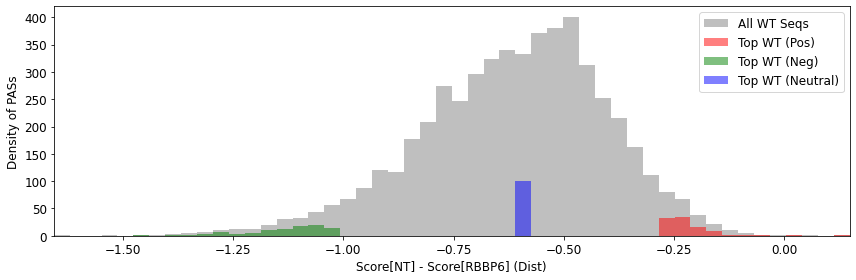

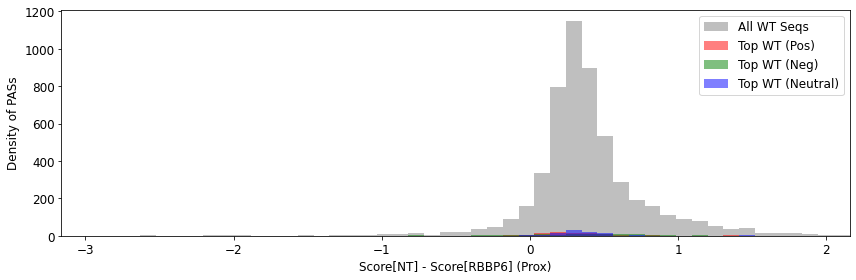

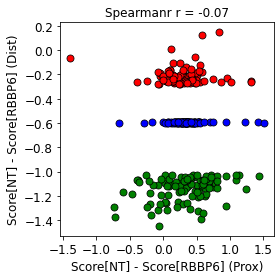

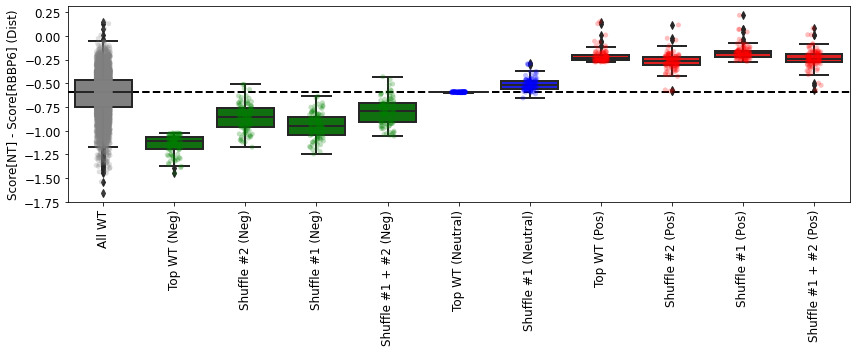

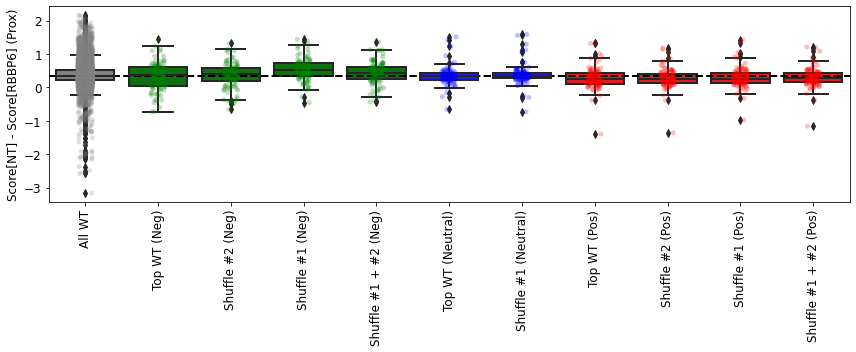

-- Top 10 5-mers shuffled in designs (pos) --
[('TTTTT', 30.0), ('CCCCC', 5.0), ('CCCCA', 5.0), ('TTAGT', 5.0), ('CCCAC', 4.0), ('TTTTC', 4.0), ('CCCTA', 4.0), ('ACCCC', 4.0), ('CCCAG', 4.0), ('AGGAT', 4.0)]


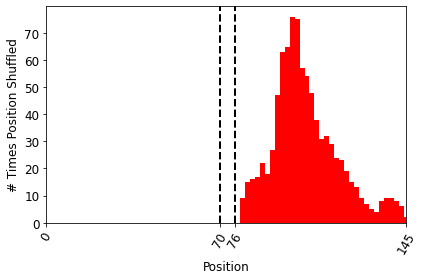

-- Top 10 5-mers shuffled in designs (neg) --
[('TGTGT', 33.0), ('AAAAA', 32.0), ('TTTGT', 22.0), ('TTGTG', 16.0), ('TGTTT', 15.0), ('GTGTG', 13.0), ('TCTGT', 12.0), ('TGTCT', 12.0), ('TTTTT', 11.0), ('TCTTT', 10.0)]


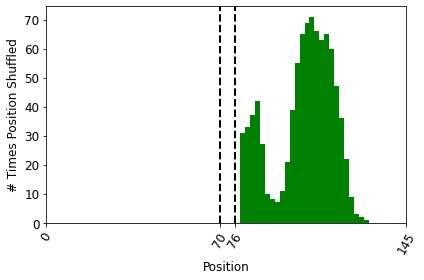

-- Top 10 5-mers shuffled in designs (neutral) --
[('', 500.0)]


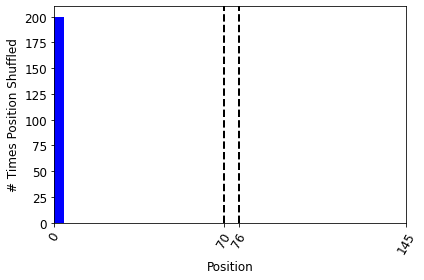

In [16]:
#Load and visualize sequence designs for specific perturbation conditions

#Condition: RBBP6, upstream, distal, window size = 9, background distribution = unif

save_prefix = 'unif_bg_'

#Parameter configuration
n_sequences = 100

window_size = 9
cell_type_1_ix = 0
cell_type_2_ix = 7
pred_cell_type_2_ix = 7

shuffle_region = 'cse'
score_ix = 2

#Visualize designs
_visualize_designs(save_prefix, n_sequences, window_size, cell_type_1_ix, cell_type_2_ix, pred_cell_type_2_ix, score_ix, shuffle_region=shuffle_region)
